# Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.append('/cvmfs/icecube.opensciencegrid.org/py3-v4.3.0/RHEL_7_x86_64/lib/python3.11/site-packages/')
import photospline
from photospline import glam_fit, ndsparse, bspline

import site
sys.path.append(site.USER_SITE)
import uproot
from scipy.interpolate import interp1d
import healpy as hp
import glob

# HAWC - Loading and reading in the data

In [2]:
elements = ["proton", "helium", "carbon", "oxygen", "neon", "magnesium", "silicon", "iron"]

files = sorted(glob.glob("pass5.1/*.root"))

main_dict = {e: {} for e in elements}

for e in elements:
    data_candidates = [file for file in files if (e in file) and ('mc' not in file)]
    weight_candidates = [file for file in files if (e in file) and ('mc' in file)]

    # reading the data files
    if len(data_candidates) == 1:
        data_file = data_candidates[0]
        with uproot.open(data_file) as f:
            t = f["XCDF"]
            main_dict[e]["nChAvail"] = t["rec.nChAvail"].array(library="np")
            main_dict[e]["nHit"]      = t["rec.nHit"].array(library="np")
            main_dict[e]["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np")
            main_dict[e]["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
            main_dict[e]["zenith"]   = t["rec.zenithAngle"].array(library="np")
            main_dict[e]["coreX"]    = t["rec.coreX"].array(library="np")
            main_dict[e]["coreY"]    = t["rec.coreY"].array(library="np")
            main_dict[e]["coreR"] = np.sqrt((main_dict[e]["coreX"]-37.19)**2+(main_dict[e]["coreY"]-246)**2)/100.
            main_dict[e]["pinc"]     = t["rec.PINC"].array(library="np")
            main_dict[e]["trueEnergy"] = t["mc.logEnergy"].array(library="np")
            # t.show()

    # read the weights files
    if len(weight_candidates) ==1:
        weight_file = weight_candidates[0]
        with uproot.open(weight_file) as f:
            t = f["XCDF"]
            main_dict[e]["gsf"] = t["sweets.IWgt.gsf"].array(library="np")
            main_dict[e]["h3a"] = t["sweets.IWgt.h3a"].array(library="np")

    # defining the initial cuts
    initial_cut = np.logical_and(main_dict[e]["nHit"] > 75, main_dict[e]["zenith"] >= 0)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["zenith"] < 1.222)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["CxPE40XnCh"] > 40)

    # applied the initial cuts here to all the arrays
    for key in main_dict[e].keys():
        main_dict[e][key] = main_dict[e][key][initial_cut]

In [3]:
main_dict

{'proton': {'nChAvail': array([1066,  999, 1074, ..., 1063, 1070,  988], dtype=uint64),
  'nHit': array([333, 998,  86, ..., 235, 110, 976], dtype=uint64),
  'CxPE40XnCh': array([ 99, 211,  65, ..., 112,  57, 135], dtype=uint64),
  'corsikaParticleId': array([14, 14, 14, ..., 14, 14, 14], dtype=uint64),
  'zenith': array([0.1919, 0.2421, 0.0982, ..., 0.727 , 0.8772, 0.0877]),
  'coreX': array([73.4, 29.9, 97.5, ..., 94. , 35.6, 99.1]),
  'coreY': array([176.3, 246.7, 276.2, ..., 255. , 179.8, 262.6]),
  'coreR': array([0.78544599, 0.07323531, 0.67448766, ..., 0.57518485, 0.66219092,
         0.64096865]),
  'pinc': array([3.09, 2.43, 1.46, ..., 1.74, 0.81, 2.37]),
  'trueEnergy': array([3.592, 5.111, 2.494, ..., 3.657, 3.863, 5.075]),
  'gsf': array([1.03459167e-03, 6.58024165e-05, 8.19134620e-04, ...,
         9.65951095e-05, 1.05589482e-03, 1.33738021e-05]),
  'h3a': array([1.05252091e-03, 6.69624836e-05, 8.06668809e-04, ...,
         9.69478026e-05, 1.02743641e-03, 1.36929351e-05])}

In [4]:
# zenith, nHit, nChAvail, coreR, true energy, corsikaParticleID, pinc, gsf, h3a

zenith, nHit, nChAvail, coreR, log_true_E, particleId, pinc, gsf, h3a = [], [], [], [], [], [], [], [], []

for e in main_dict.keys():
    zenith.append(main_dict[e]["zenith"])
    nHit.append(main_dict[e]["nHit"])
    nChAvail.append(main_dict[e]["nChAvail"])
    coreR.append(main_dict[e]["coreR"])
    log_true_E.append(main_dict[e]["trueEnergy"])
    particleId.append(main_dict[e]["corsikaParticleId"])
    pinc.append(main_dict[e]["pinc"])
    gsf.append(main_dict[e]["gsf"])
    h3a.append(main_dict[e]["h3a"])

zenith = np.concatenate(zenith)
nHit = np.concatenate(nHit)
nChAvail = np.concatenate(nChAvail)
coreR = np.concatenate(coreR)
log_true_E = np.concatenate(log_true_E)
particleId = np.concatenate(particleId)
pinc = np.concatenate(pinc)
gsf = np.concatenate(gsf)
h3a = np.concatenate(h3a)

# HAWC - Calculate the reco energy

In [5]:
def get_reco_energy(zenith, nHit, nChAvail, coreR):
    tab1 = photospline.SplineTable(f'pass5_spline_combined3d.fits')
    x = np.cos(zenith)
    y = nHit/nChAvail
    z = coreR

    reco_energy = []

    for i in range(x.size):
        coord3d = [x[i], y[i], z[i]]
        try:
            centers = tab1.search_centers(coord3d)
            reco_energy.append(tab1.evaluate(coord3d, centers))
        except:
            reco_energy.append(-1)

    reco_energy = np.array(reco_energy)

    return reco_energy

In [6]:
reco_energy = get_reco_energy(zenith, nHit, nChAvail, coreR)

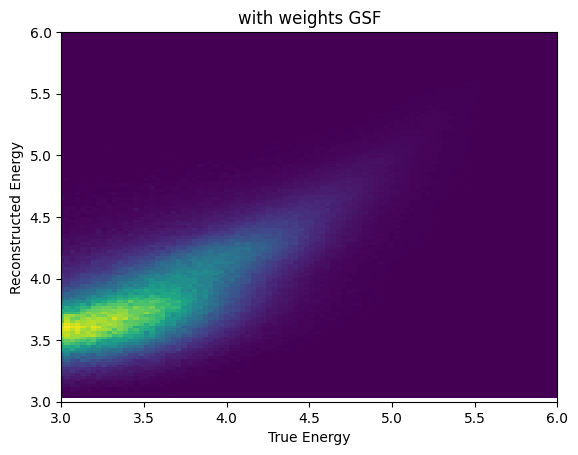

In [7]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = gsf)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

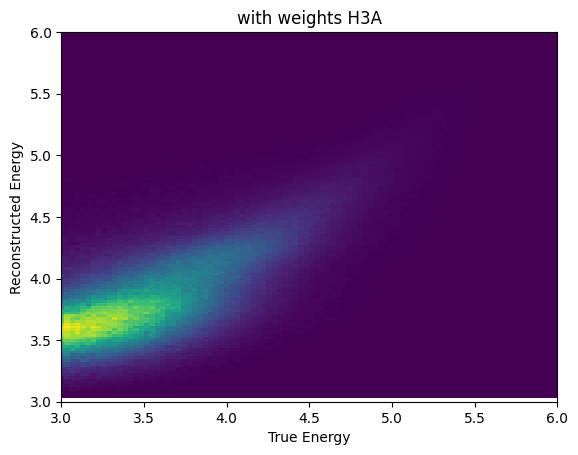

In [8]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = h3a)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights H3A')
plt.show()

# HAWC - Converting particle IDs to atomic numbers

In [9]:
particle_ids = {14: 1, 402 : 2, 1206 : 6, 2412: 12, 2010 : 10, 1608: 8, 2814: 14, 5626: 26}

In [10]:
atomic_number = []
for i in particleId:
    atomic_number.append(particle_ids[i])

atomic_number = np.array(atomic_number)

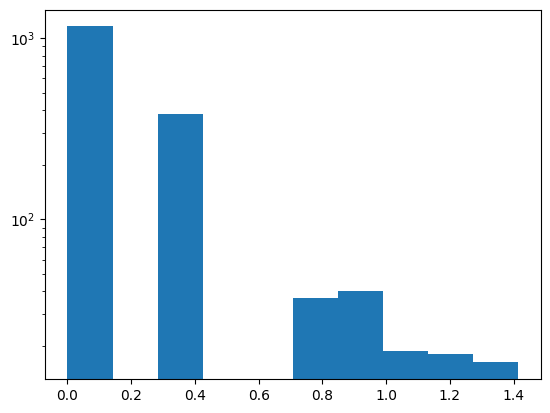

In [11]:
plt.hist(np.log10(atomic_number), weights = gsf)
plt.yscale('log')
plt.show()

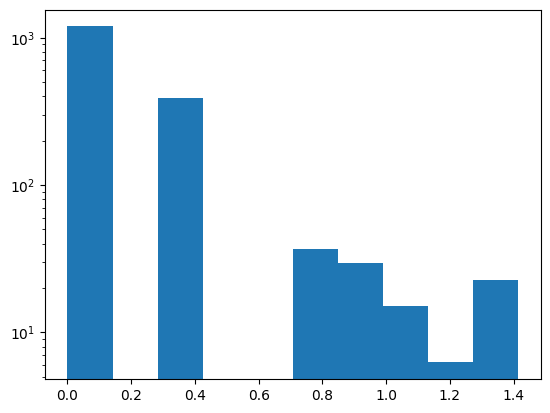

In [12]:
plt.hist(np.log10(atomic_number), weights = h3a)
plt.yscale('log')
plt.show()

In [13]:
# mean_logz = np.average(np.log10(atomic_number), weights = weights)
# mean_logz

# HAWC - Energy cuts on reco energy applied to true energy

- 12 total cuts going from bin0 to bin11

In [14]:
min_energies = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0]
max_energies = [3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.98, 5.15, 5.44, 5.68, 6.0, 6.9]
pinc_vals = [1.3, 1.4, 1.5, 1.4, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]

In [15]:
def cut_energy(min_energy, max_energy, pinc_val):
    cut = np.logical_and(min_energy <= reco_energy, max_energy > reco_energy)
    cut = np.logical_and(cut, pinc > pinc_val)

    return cut

In [16]:
cuts = []

for i , j , k in zip(min_energies, max_energies, pinc_vals):
    cut = cut_energy(i, j , k)
    cuts.append(cut)

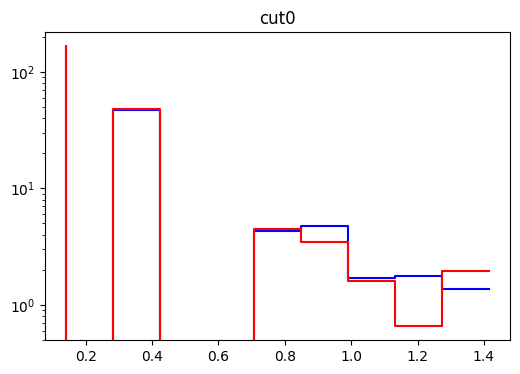

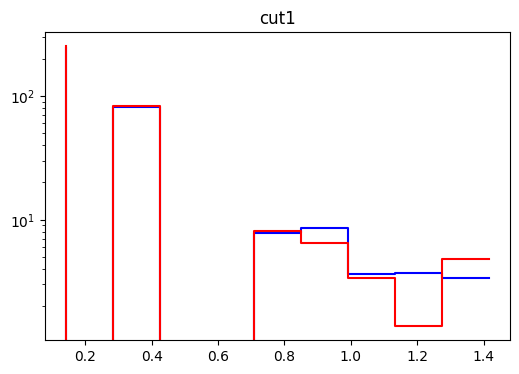

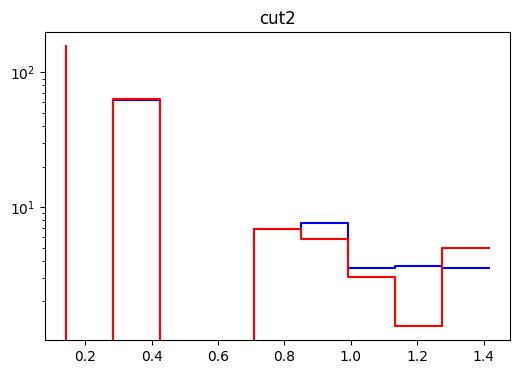

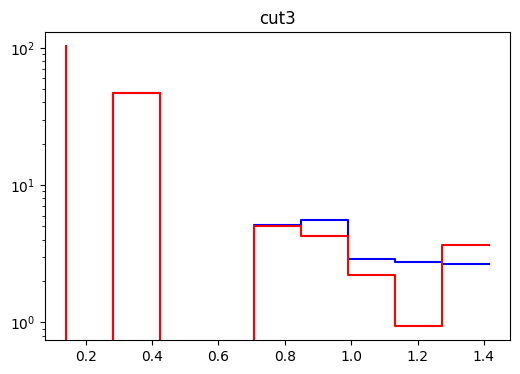

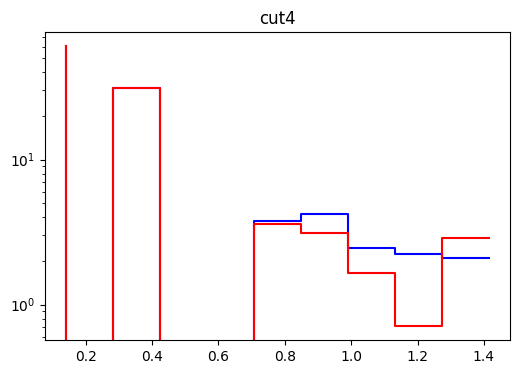

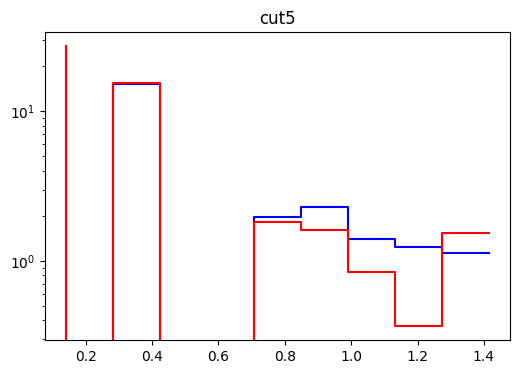

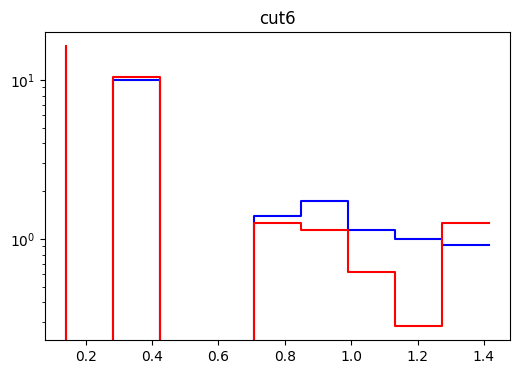

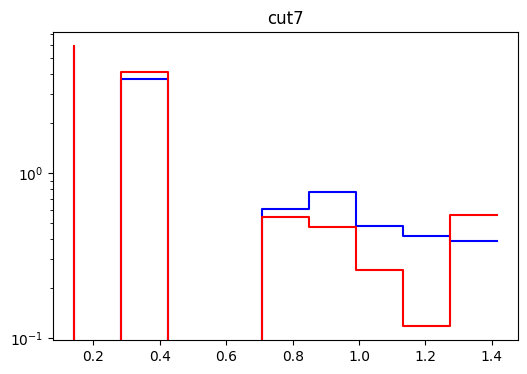

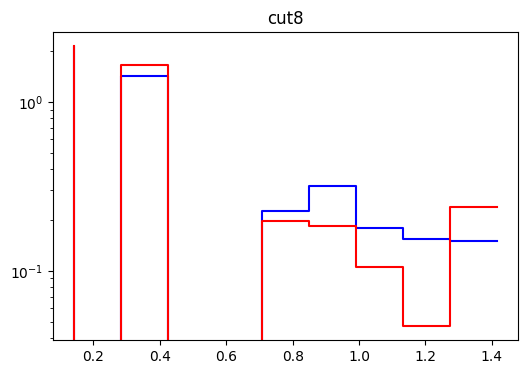

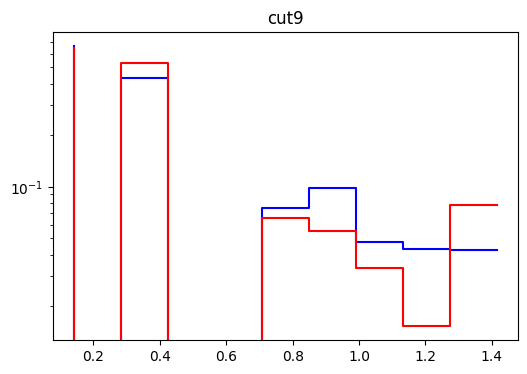

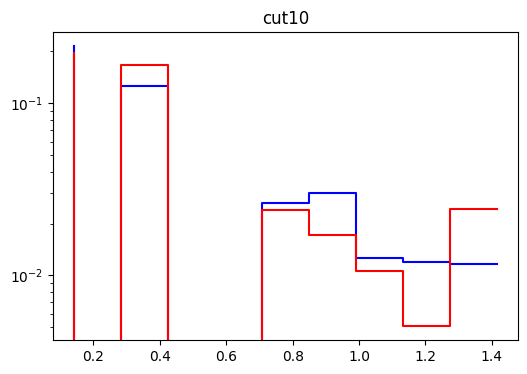

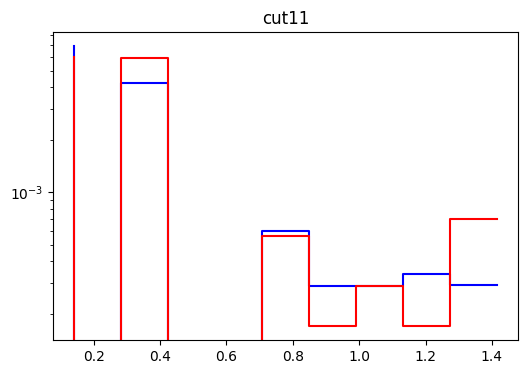

In [17]:
mean_energies_gsf = []
mean_energies_h3a = []
mean_atomic_gsf = []
mean_atomic_h3a = []

for i, cut in enumerate(cuts):
    mean_energy_gsf = np.average(log_true_E[cut], weights = gsf[cut])
    mean_energy_h3a = np.average(log_true_E[cut], weights = h3a[cut])
    mean_logz_gsf = np.average(np.log10(atomic_number[cut]), weights = gsf[cut])
    mean_logz_h3a = np.average(np.log10(atomic_number[cut]), weights = h3a[cut])

    mean_energies_gsf.append(mean_energy_gsf)
    mean_energies_h3a.append(mean_energy_h3a)
    mean_atomic_gsf.append(mean_logz_gsf)
    mean_atomic_h3a.append(mean_logz_h3a)

    bin_gsf, edge_gsf = np.histogram(np.log10(atomic_number[cut]), weights = gsf[cut])
    bin_h3a, edge_h3a = np.histogram(np.log10(atomic_number[cut]), weights = h3a[cut])
    plt.figure(figsize = (6, 4))
    plt.step(edge_gsf[1:], bin_gsf, 'b')
    plt.step(edge_h3a[1:], bin_h3a, 'r')
    plt.yscale('log')
    plt.title(f"cut{i}")
    plt.show()

mean_energies_gsf = np.array(mean_energies_gsf)
mean_energies_h3a = np.array(mean_energies_h3a)
mean_atomic_gsf = np.array(mean_atomic_gsf)
mean_atomic_h3a = np.array(mean_atomic_h3a)

In [18]:
total_n_gsf, total_edges_gsf = np.histogram(log_true_E, bins = mean_energies_gsf, weights = gsf)
total_n_h3a, total_edges_h3a = np.histogram(log_true_E, bins = mean_energies_h3a, weights = h3a)

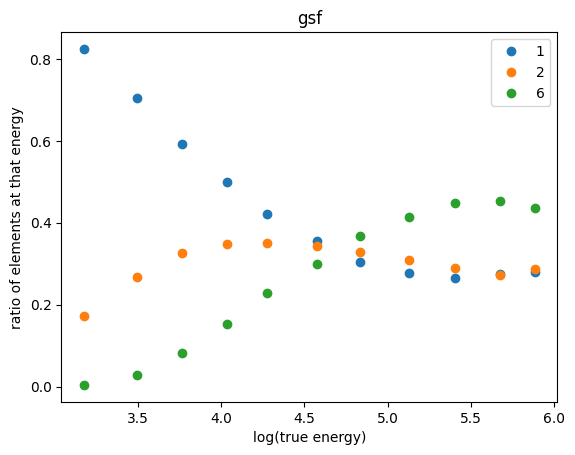

In [19]:
# for i in np.unique(atomic_number):
# gsf
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = mean_energies_gsf, weights = gsf[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_gsf, weights = gsf[atomic_number == i])

    frac = ni/total_n_gsf
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("gsf")
plt.xlabel("log(true energy)")
plt.ylabel("ratio of elements at that energy")
plt.legend()
plt.show()

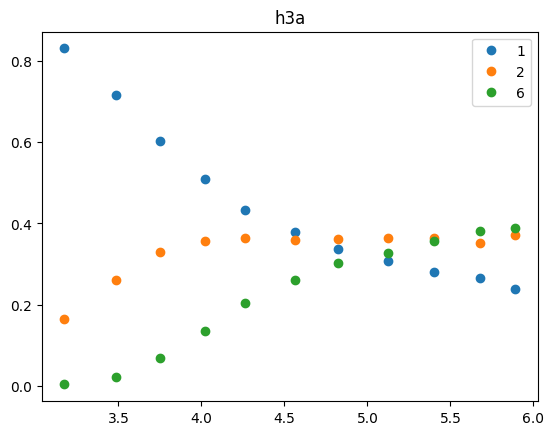

In [20]:
# h3a
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = mean_energies_h3a, weights = h3a[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_h3a, weights = h3a[atomic_number == i])

    frac = ni/total_n_h3a
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("h3a")
plt.legend()
plt.show()

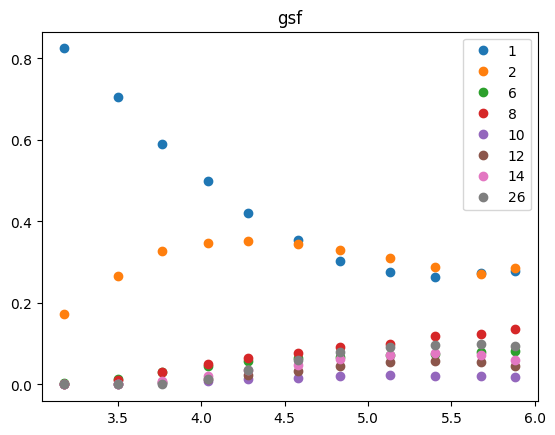

In [21]:
# gsf
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_gsf, weights = gsf[atomic_number == i])

    frac = ni/ total_n_gsf
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("gsf")
plt.legend()
plt.show()

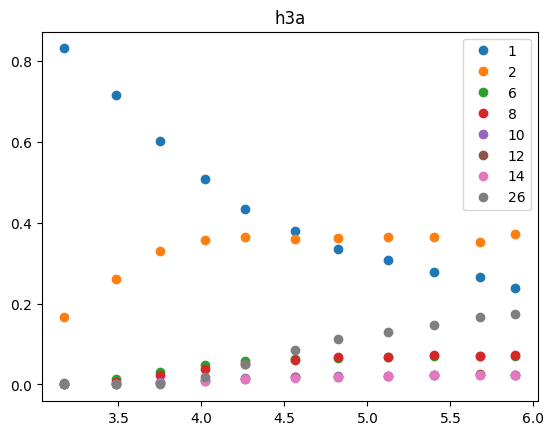

In [22]:
# h3a
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_h3a, weights = h3a[atomic_number == i])

    frac = ni/ total_n_h3a
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("h3a")
plt.legend()
plt.show()

In [23]:
mean_rid_gsf = mean_energies_gsf - mean_atomic_gsf
mean_rid_gsf

array([2.80205048, 3.03208803, 3.31438517, 3.56712851, 3.80969053,
       4.02567307, 4.28745949, 4.51749759, 4.80888662, 5.08947799,
       5.37691748, 5.64234591])

In [24]:
mean_rid_h3a = mean_energies_h3a - mean_atomic_h3a
mean_rid_h3a

array([2.81710572, 3.03712762, 3.31220047, 3.56421796, 3.81369619,
       4.03916496, 4.31332902, 4.54941748, 4.8367598 , 5.10255633,
       5.37360702, 5.61040444])

# IceCube - Reading and viewing the files

- nchannel: number of active channels
- llhZen: reconstructed zenith
- llhAz: reconstructed azimuth
- zenith: zenith angle
- azimuth: azimuth angle
- mc_energy: true energy
- type: proton, helium, nitrogen, aluminium, iron
- energy: true energy
- GaisserH3a: weights
- Hoerandel: weights
- GlobalFitGST: weights
- reco_energy: reconstructed energy

In [25]:
dst = np.load('dst_20904_v2.npz')

print(dst.files)

# accessing individual numpy arrays from the file
# dst['zenith']

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'reco_energy']


[4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]

bin edges in log for the reco energy

# IceCube - Applying initial cuts

In [26]:
imain_cut = np.logical_and(dst['nchannel'] > 10, dst['llhZen'] < 70)

ienergy = np.log10(dst['energy'][imain_cut])
weights_h3a = dst['GaisserH3a'][imain_cut]
# weights_2 = dst['Hoerandel'][imain_cut]
weights_gsf = dst['GlobalSplineFit5Comp'][imain_cut]
ireco_energy = dst['reco_energy'][imain_cut]
inchannel = dst['nchannel'][imain_cut]
ireco_zenith = dst['llhZen'][imain_cut]
izenith = dst['zenith'][imain_cut]
itype = dst['type'][imain_cut]

iparticle_ids = {2212: 1, 1000020040: 2, 1000070140: 7, 1000130270: 13, 1000260560: 26}

In [27]:
iatomic = []
for i in itype:
    iatomic.append(iparticle_ids[i])

iatomic = np.array(iatomic)

# IceCube - Binning the data

## approach 1
- argsort on reco_energy
- apply it on all the other arrays
- traverse through reco_energy
- find emin and emax for it
- get those indices between emin and emax, including emin and excluding emax
- define that as a cut
- apply that cut on true energy and weights
- get mean energy and mean atomic
- get mean ridgidity
- compare it with HAWC's mean ridgidity
- find the min of all the comparisions
- store the emin and emax as a tuple to use later

In [28]:
targets = mean_rid_gsf

In [38]:
# argsort on reco_energy and apply it to all the other arrays
sorted_idx_reco_energy = np.argsort(ireco_energy)
trueE = ienergy[sorted_idx_reco_energy]
atomic = iatomic[sorted_idx_reco_energy]
use_weights_h3a = weights_h3a[sorted_idx_reco_energy]
W = weights_gsf[sorted_idx_reco_energy]
reco = ireco_energy[sorted_idx_reco_energy]

In [40]:
N = len(reco)

cumW = np.concatenate(([0.0], np.cumsum(W)))
cumE = np.concatenate(([0.0], np.cumsum(W * trueE)))
cumL = np.concatenate(([0.0], np.cumsum(W * np.log10(atomic))))

In [41]:
j_indices = np.searchsorted(reco, reco + 0.25, side='left')

In [42]:
candidate_rid = np.full(N, np.nan)

candidate_emin = np.full(N, np.nan)
candidate_emax = np.full(N, np.nan)

valid_idx = np.where(j_indices > np.arange(N))[0]

for i in valid_idx:
    
    j = j_indices[i]
    
    # Sum of weights in candidate bin:
    weight_sum = cumW[j] - cumW[i]
    
    if weight_sum <= 0:
        continue
    # Compute weighted averages over the window [i, j)
    weighted_E = (cumE[j] - cumE[i]) / weight_sum
    weighted_L = (cumL[j] - cumL[i]) / weight_sum
    candidate_rid[i] = weighted_E - weighted_L
    candidate_emin[i] = reco[i]
    # Let candidate's emax be the last reco energy in the window.
    candidate_emax[i] = reco[j - 1]

In [43]:
targets

array([2.80205048, 3.03208803, 3.31438517, 3.56712851, 3.80969053,
       4.02567307, 4.28745949, 4.51749759, 4.80888662, 5.08947799,
       5.37691748, 5.64234591])

In [44]:
# Filter to valid candidate bins:
valid_candidate_rid = candidate_rid[valid_idx]
valid_emin = candidate_emin[valid_idx]
valid_emax = candidate_emax[valid_idx]

store_cuts = []      # To store best (emin, emax) for each target
min_diff_values = [] # To store the corresponding differences

for target in targets:
    differences = np.abs(valid_candidate_rid - target)
    best_idx = np.argmin(differences)
    best_cut = (valid_emin[best_idx], valid_emax[best_idx])
    store_cuts.append(best_cut)
    min_diff_values.append(differences[best_idx])

# Display results:
for i, cut in enumerate(store_cuts):
    print(f"Target {targets[i]}: emin = {cut[0]}, emax = {cut[1]}, diff = {min_diff_values[i]}")

Target 2.8020504794992003: emin = 3.880659818649292, emax = 4.130659580230713, diff = 1.1535111525208213
Target 3.0320880301341244: emin = 3.880659818649292, emax = 4.130659580230713, diff = 0.9234736018858971
Target 3.314385171747565: emin = 3.880659818649292, emax = 4.130659580230713, diff = 0.6411764602724563
Target 3.5671285095884038: emin = 3.880659818649292, emax = 4.130659580230713, diff = 0.38843312243161776
Target 3.8096905331551385: emin = 3.880659818649292, emax = 4.130659580230713, diff = 0.14587109886488303
Target 4.025673066016987: emin = 3.9870543479919434, emax = 4.237049579620361, diff = 1.221519602001564e-05
Target 4.287459485766737: emin = 4.306577205657959, emax = 4.556575775146484, diff = 1.0716449949654816e-09
Target 4.517497593364898: emin = 4.624240398406982, emax = 4.874239921569824, diff = 7.751286457136075e-08
Target 4.8088866220609265: emin = 4.99198579788208, emax = 5.241982936859131, diff = 6.723698362520736e-07
Target 5.089477991695051: emin = 5.382532119

In [30]:
# def compute_mean_rid(cut, true_energy, atomic, weights):
    
#     mean_true = np.average(true_energy[cut], weights = weights[cut])
#     mean_log_atomic = np.average(np.log10(atomic[cut]), weights = weights[cut])

#     return mean_true - mean_log_atomic

In [31]:
# candidate_bins = []
# i = 0

# while i < len(sorted_reco):
#     emin = sorted_reco[i]
#     emax_target = emin + 0.25
#     j = i
#     while j < len(sorted_reco) and sorted_reco[j] < emax_target:
#         j += 1
#     if j == i:
#         i += 1
#         continue
#     indices = np.arange(i, j)
#     candidate_bins.append({
#         'emin': emin,
#         'emax': sorted_reco[j-1],  # the last event in the candidate bin
#         'indices': indices
#     })
#     # i = i + 1
#     i = j

In [32]:
# for candidate in candidate_bins:
#     idx = candidate['indices']
#     candidate['rid_gsf'] = compute_mean_rid(idx, sorted_true, sorted_atomic, sorted_weights_gsf)
#     candidate['rid_h3a'] = compute_mean_rid(idx, sorted_true, sorted_atomic, sorted_weights_h3a)
#     # (Optional: store also the candidate’s mean energy if needed)
#     # candidate['mean_energy'] = np.average(sorted_true[idx], weights=sorted_weights_gsf[idx])

In [31]:
# # min_val = []
# # store_cuts = []

# # for i, what in enumerate(use_ireco_energy):
# #     emin = what
# #     emax = what + 0.25
# #     cut = np.logical_and(use_ireco_energy >= emin, use_ireco_energy < emax)

# #     mean_irid = compute_mean_rid(cut, use_ienergy, use_iatomic, use_weights_gsf)
    
# #     for val in mean_rid_gsf:
# #         comapre = np.abs(mean_irid - val)
# #         if len(min_val) == 0:
# #             min_val.append(compare)
# #         else:
# #             if compare < min_val[0]:
# #                 min_val[0] = compare
    
# store_cuts = []      # To store the best (emin, emax) candidate for each target HAWC bin.
# min_diff_values = [] # To store the minimum difference for each target.

# # Loop over each target HAWC rid value
# for target in mean_rid_gsf:
#     best_cut = None
#     best_diff = np.inf
#     # Iterate over every possible candidate starting point in the sorted reco energy array.
#     for emin in use_ireco_energy:
#         emax = emin + 0.25
#         # Define a cut: all events with reco energy in [emin, emax)
#         cut = (use_ireco_energy >= emin) & (use_ireco_energy < emax)
#         # Skip if no events are in this candidate bin
#         if np.count_nonzero(cut) == 0:
#             continue
#         # Compute the candidate's mean ridgidity using your helper function.
#         candidate_rid = compute_mean_rid(cut, use_ienergy, use_iatomic, use_weights_gsf)
#         diff = np.abs(candidate_rid - target)
#         # Update the best candidate if this candidate's difference is smaller.
#         if diff < best_diff:
#             best_diff = diff
#             best_cut = (emin, emax)
#     # Store the best candidate for this HAWC bin
#     store_cuts.append(best_cut)
#     min_diff_values.append(best_diff)

# # Now store_cuts holds, for each target in mean_rid_gsf, the candidate energy cut (emin, emax)
# # that minimizes the difference in computed ridgidity.
# print("Best candidate cuts for each target HAWC rid value:")
# for i, cut in enumerate(store_cuts):
#     print(f"Target {mean_rid_gsf[i]:.3f}: emin = {cut[0]:.3f}, emax = {cut[1]:.3f}, diff = {min_diff_values[i]:.3f}")

## approach 2
- argsort on true energy
- apply in on all the other arrays
- traverse through true energy
- find emin and emax for it
- get those indices between emin and emax, including emin and excluding emax
- define that as a cut
- apply that cut on true energy and weights
- get mean energy and mean atomic
- get mean ridgidity
- compare it with HAWC's mean ridgidity
- find the min of all the comparisions
- store the emin and emax as a tuple to use later

In [47]:
# sorted_indices = np.argsort(ienergy)
# iatomic = iatomic[sorted_indices]
# weights_h3a = weights_h3a[sorted_indices]
# weights_gsf = weights_gsf[sorted_indices]
# sorted_ienergy = np.array(sorted(ienergy))
ireco_energy

array([4.42289448, 4.5216279 , 4.63815641, ..., 4.31678152, 4.15810585,
       5.13097143])

In [78]:
# total_n1, total_edges1 = np.histogram(ienergy, bins = mean_energies, weights = weights_gsf)

In [79]:
# total_n1

In [80]:
# for i in [1, 2, 6]:
#     if i >= 6:
#         ni, ei = np.histogram(ienergy[iatomic >= i], bins = mean_energies, weights = weights_1[iatomic >= i])
#     else:
#         ni, ei = np.histogram(ienergy[iatomic == i], bins = mean_energies, weights = weights_1[iatomic == i])
    
#     # ni, ei = np.histogram(ienergy[iatomic == i], bins = imean_energies, weights = weights_1[iatomic == i])
#     frac = ni/total_n1
#     plt.plot(ei[1:], frac, 'o',label=str(i))
# plt.legend()
# plt.title("IceCube")
# plt.xlim(4, 7)
# plt.ylim(0, 1)
# plt.show()

# for i in [1,2,6]:
#     if i >= 6:
#         ni, ei = np.histogram(true_log_E[atomic_number >= i], bins = mean_energies, weights = weights[atomic_number >= i])
#     else:
#         ni, ei = np.histogram(true_log_E[atomic_number == i], bins = mean_energies, weights = weights[atomic_number == i])

#     frac = ni/total_n
#     plt.plot(ei[1:], frac, 'o',label=str(i))
# plt.legend()
# plt.title("HAWC")
# plt.xlim(4, 7)
# plt.ylim(0, 1)
# plt.show()

In [81]:
# # GaisserH3a
# plt.hist2d(ienergy, ireco_energy, bins = 100, weights = weights_1)
# plt.ylim(top = 6)
# plt.xlim(right = 7)
# plt.xlabel('True Energy')
# plt.ylabel('Reconstructed Energy')
# plt.title('GaisserH3a')
# plt.show()

In [82]:
# # GlobalFitGST
# plt.hist2d(ienergy, ireco_energy, bins = 100, weights = weights_3)
# plt.ylim(top = 6)
# plt.xlim(right = 7)
# plt.xlabel('True Energy')
# plt.ylabel('Reconstructed Energy')
# plt.title('GlobalFitGST')
# plt.show()

In [83]:
# imean_energies = []
# imean_atomics = []

# bins = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0, 6.9]

# for i in range(len(bins) - 1):
#     cut = np.logical_and(ireco_energy >= bins[i], ireco_energy < bins[i + 1])

#     mean_energy1 = np.average(ienergy[cut], weights = weights_1[cut])
#     mean_energy2 = np.average(ienergy[cut], weights = weights_2[cut])
#     mean_energy3 = np.average(ienergy[cut], weights = weights_3[cut])

#     mean_atomic1 = np.average(iatomic[cut], weights = weights_1[cut])
#     mean_atomic2 = np.average(iatomic[cut], weights = weights_2[cut])
#     mean_atomic3 = np.average(iatomic[cut], weights = weights_3[cut])

#     imean_energies.append(mean_energy1)
#     imean_atomics.append(mean_atomic1)

# imean_energies = np.array(imean_energies)
# imean_atomics = np.log10(np.array(imean_atomics))

In [84]:
# imean_rid = imean_energies - imean_atomics
# imean_rid